In [ ]:
from google.colab import files

# Upload the ZIP file
uploaded = files.upload()


In [ ]:
import os
import time
import copy
import glob
import random
import multiprocessing
import zipfile

import numpy as np
import pandas as pd
from PIL import Image

from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18, resnet34

In [ ]:
# Unzip data.zip into current directory
with zipfile.ZipFile("data.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

In [ ]:
# View sample files from one of the folders
!ls data/train/NORMAL | head

IM-0115-0001.jpeg
IM-0117-0001.jpeg
IM-0119-0001.jpeg
IM-0122-0001.jpeg
IM-0125-0001.jpeg
IM-0127-0001.jpeg
IM-0128-0001.jpeg
IM-0129-0001.jpeg
IM-0131-0001.jpeg
IM-0133-0001.jpeg


In [ ]:
base_dir = "data"

train_normal_dir = os.path.join(base_dir, "train", "NORMAL")
train_pneumonia_dir = os.path.join(base_dir, "train", "PNEUMONIA")
test_normal_dir = os.path.join(base_dir, "test", "NORMAL")
test_pneumonia_dir = os.path.join(base_dir, "test", "PNEUMONIA")

train_normal = glob.glob(os.path.join(train_normal_dir, "*"))
train_pneumonia = glob.glob(os.path.join(train_pneumonia_dir, "*"))
test_normal = glob.glob(os.path.join(test_normal_dir, "*"))
test_pneumonia = glob.glob(os.path.join(test_pneumonia_dir, "*"))

print("Train NORMAL:", len(train_normal))
print("Train PNEUMONIA:", len(train_pneumonia))
print("Test NORMAL:", len(test_normal))
print("Test PNEUMONIA:", len(test_pneumonia))


Train NORMAL: 288
Train PNEUMONIA: 306
Test NORMAL: 108
Test PNEUMONIA: 153


In [ ]:
train_paths = train_normal + train_pneumonia
test_paths = test_normal + test_pneumonia

In [ ]:
train_labels = [0] * len(train_normal) + [1] * len(train_pneumonia)
test_labels = [0] * len(test_normal) + [1] * len(test_pneumonia)

In [ ]:
print(len(train_paths), len(train_labels))
print(len(test_paths), len(test_labels))

594 594
261 261


In [ ]:
train_paths, valid_paths, train_labels, valid_labels = train_test_split(train_paths,
                                                                        train_labels,
                                                                        stratify = train_labels)

In [ ]:
def show_random_images():
    path_random_normal = random.choice(train_normal)
    path_random_abnormal = random.choice(train_pneumonia)

    fig = plt.figure(figsize=(10, 10))

    ax1 = plt.subplot(1, 2, 1)
    ax1.imshow(Image.open(path_random_normal).convert("LA"))
    ax1.set_title("Normal X-ray")
    ax1.axis('off')  # Optional: hide axes

    ax2 = plt.subplot(1, 2, 2)
    ax2.imshow(Image.open(path_random_abnormal).convert("LA"))
    ax2.set_title("Abnormal X-ray")
    ax2.axis('off')  # Optional: hide axes

    plt.tight_layout()
    plt.show()


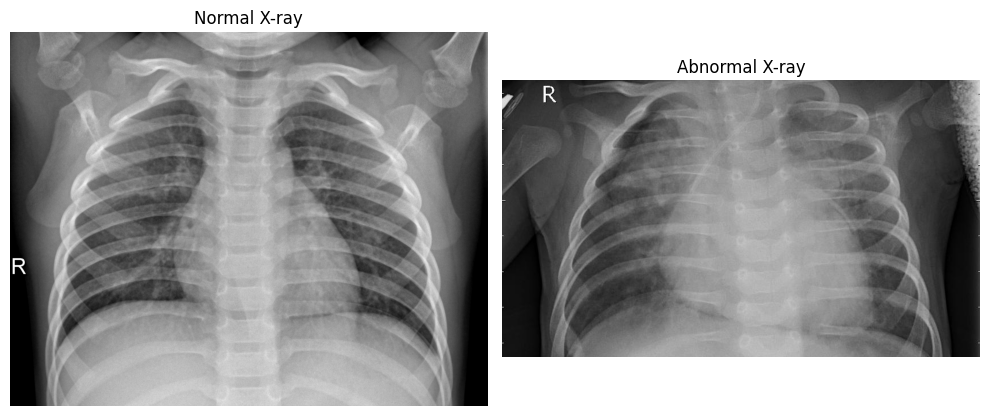

In [ ]:
show_random_images()

In [ ]:
class XrayDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        path = self.paths[index]
        image = Image.open(path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label = self.labels[index]
        label = torch.tensor([label])

        return image, label

In [ ]:
resnet = resnet18()

In [ ]:
class PneumoniaNet(nn.Module):
    def __init__(self, pretrained=True):
        super(PneumoniaNet, self).__init__()
        self.backbone = resnet18(pretrained=pretrained)
        self.fc = nn.Linear(in_features=512, out_features=1)

    def forward(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        x = self.backbone.avgpool(x)

        x = x.view(x.size(0), 512)
        x = self.fc(x)

        return x



In [ ]:
image_size = (500, 500)

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=15),
    transforms.Resize(size=image_size),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=image_size),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = XrayDataset(train_paths, train_labels, train_transform)
valid_dataset = XrayDataset(valid_paths, valid_labels, test_transform)

In [ ]:
pretrained = True

model = PneumoniaNet(pretrained=pretrained)

num_epochs = 2
train_batch_size = 8
valid_batch_size = 8

train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, num_workers = min(4, multiprocessing.cpu_count()), shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=valid_batch_size, num_workers = min(4, multiprocessing.cpu_count()), shuffle=False)

dataloaders = {
    "train": train_dataloader,
    "val": valid_dataloader
}

logging_steps = {
    "train": len(dataloaders["train"]) // 10,
    "val": len(dataloaders["val"]) // 10
}

batch_sizes = {
    "train": train_batch_size,
    "val": valid_batch_size
}
dataset_sizes = {
    "train": len(train_dataset),
    "val": len(valid_dataset)
}

lr = 0.001
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=lr)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 134MB/s]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

PneumoniaNet(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [ ]:
def train_model(model, criterion, optimizer, num_epochs, device=device):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0

    for epoch in tqdm(range(num_epochs), leave=False):
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for i, (inputs, labels) in tqdm(enumerate(dataloaders[phase]),
                                           leave=False,
                                           total=len(dataloaders[phase])):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)

                    preds = outputs.sigmoid() > 0.5
                    loss = criterion(outputs, labels.float())

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                if (i % logging_steps[phase] == 0) & (i > 0):
                    avg_loss = running_loss / ((i + 1) * batch_sizes[phase])
                    avg_acc = running_corrects / ((i + 1) * batch_sizes[phase])

                    print(f"[{phase}]: {epoch+1} / {num_epochs} | loss: {avg_loss} | acc: {avg_acc}")

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
    time_elapsed = time.time() - since

    print(f"training took {time_elapsed} seconds")

    model.load_state_dict(best_model_wts)

    return model


In [ ]:
model = train_model(model, criterion, optimizer, num_epochs)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[train]: 1 / 2 | loss: 0.6834744345396757 | acc: 0.8333333730697632
[train]: 1 / 2 | loss: 0.5616830529814417 | acc: 0.8181818723678589
[train]: 1 / 2 | loss: 0.629089662572369 | acc: 0.7734375
[train]: 1 / 2 | loss: 0.5622232398461728 | acc: 0.7976190447807312
[train]: 1 / 2 | loss: 0.5193177649321464 | acc: 0.8076923489570618
[train]: 1 / 2 | loss: 0.48106456007207593 | acc: 0.8185483813285828
[train]: 1 / 2 | loss: 0.4429914749537905 | acc: 0.8368055820465088
[train]: 1 / 2 | loss: 0.4065446596501804 | acc: 0.8475609421730042
[train]: 1 / 2 | loss: 0.38936559143273725 | acc: 0.8586956858634949
[train]: 1 / 2 | loss: 0.3882441364374815 | acc: 0.8578431606292725
[train]: 1 / 2 | loss: 0.3661683404019901 | acc: 0.8571429252624512
train Loss: 0.3686 Acc: 0.8629


  0%|          | 0/19 [00:00<?, ?it/s]

[val]: 1 / 2 | loss: 20.98336124420166 | acc: 0.4375
[val]: 1 / 2 | loss: 21.664730707804363 | acc: 0.375
[val]: 1 / 2 | loss: 18.79876136779785 | acc: 0.46875
[val]: 1 / 2 | loss: 16.99657096862793 | acc: 0.5250000357627869
[val]: 1 / 2 | loss: 16.952006340026855 | acc: 0.5208333730697632
[val]: 1 / 2 | loss: 17.332628795078822 | acc: 0.5178571939468384
[val]: 1 / 2 | loss: 17.630894899368286 | acc: 0.5
[val]: 1 / 2 | loss: 18.99694781833225 | acc: 0.472222238779068
[val]: 1 / 2 | loss: 20.549284744262696 | acc: 0.4375
[val]: 1 / 2 | loss: 20.450452631170098 | acc: 0.4318181872367859
[val]: 1 / 2 | loss: 19.551457405090332 | acc: 0.4583333432674408
[val]: 1 / 2 | loss: 19.046225034273586 | acc: 0.4711538553237915
[val]: 1 / 2 | loss: 19.08805479322161 | acc: 0.4642857313156128
[val]: 1 / 2 | loss: 19.220585759480795 | acc: 0.46666669845581055
[val]: 1 / 2 | loss: 19.084743857383728 | acc: 0.4609375
[val]: 1 / 2 | loss: 18.208515840418197 | acc: 0.4852941334247589
[val]: 1 / 2 | loss: 

  0%|          | 0/56 [00:00<?, ?it/s]

[train]: 2 / 2 | loss: 0.35698450294633705 | acc: 0.875
[train]: 2 / 2 | loss: 0.2823563268916173 | acc: 0.8977273106575012
[train]: 2 / 2 | loss: 0.2629212934989482 | acc: 0.90625
[train]: 2 / 2 | loss: 0.2576696966730413 | acc: 0.910714328289032
[train]: 2 / 2 | loss: 0.24846658726724294 | acc: 0.9182692766189575
[train]: 2 / 2 | loss: 0.25712563530091315 | acc: 0.9072580337524414
[train]: 2 / 2 | loss: 0.23826230824407604 | acc: 0.913194477558136
[train]: 2 / 2 | loss: 0.2216385103784865 | acc: 0.9176828861236572
[train]: 2 / 2 | loss: 0.21030409363827304 | acc: 0.9211956858634949
[train]: 2 / 2 | loss: 0.20862316357556218 | acc: 0.9215686321258545
[train]: 2 / 2 | loss: 0.2175967849242235 | acc: 0.910714328289032
train Loss: 0.2191 Acc: 0.9169


  0%|          | 0/19 [00:00<?, ?it/s]

[val]: 2 / 2 | loss: 0.7968040015548468 | acc: 0.875
[val]: 2 / 2 | loss: 0.9022768673797449 | acc: 0.8333333730697632
[val]: 2 / 2 | loss: 0.6769274364196463 | acc: 0.875
[val]: 2 / 2 | loss: 0.5426370698376559 | acc: 0.9000000357627869
[val]: 2 / 2 | loss: 0.4980597163375933 | acc: 0.8958333730697632
[val]: 2 / 2 | loss: 0.44368470376191127 | acc: 0.8928571939468384
[val]: 2 / 2 | loss: 0.3921389279057621 | acc: 0.90625
[val]: 2 / 2 | loss: 0.41029832074289313 | acc: 0.8888888955116272
[val]: 2 / 2 | loss: 0.3788244230381679 | acc: 0.9000000357627869
[val]: 2 / 2 | loss: 0.3552494853131727 | acc: 0.9090909361839294
[val]: 2 / 2 | loss: 0.3336113422556082 | acc: 0.9166666865348816
[val]: 2 / 2 | loss: 0.3080816849699029 | acc: 0.9230769872665405
[val]: 2 / 2 | loss: 0.28668000340777716 | acc: 0.9285714626312256
[val]: 2 / 2 | loss: 0.28340182904697336 | acc: 0.9250000715255737
[val]: 2 / 2 | loss: 0.28011739351131837 | acc: 0.9140625
[val]: 2 / 2 | loss: 0.2663020759321037 | acc: 0.91

In [ ]:
# Define paths
test_normal_dir = os.path.join(base_dir, "test", "NORMAL")
test_pneumonia_dir = os.path.join(base_dir, "test", "PNEUMONIA")

# Get file paths
test_normal_paths = glob.glob(os.path.join(test_normal_dir, "*"))
test_pneumonia_paths = glob.glob(os.path.join(test_pneumonia_dir, "*"))

# Combine paths and labels
test_paths = test_normal_paths + test_pneumonia_paths
test_labels = [0] * len(test_normal_paths) + [1] * len(test_pneumonia_paths)

In [ ]:
len(test_paths), len(test_labels)

(261, 261)

In [ ]:
test_dataset = XrayDataset(test_paths, test_labels, test_transform)

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, drop_last=False)

In [ ]:
y_pred = []
y_true = []

for i, (tensors, labels) in tqdm(enumerate(test_dataloader), leave=False, total=len(test_dataloader)):
  with torch.no_grad():
    tensors = tensors.to(device)
    predictions = model(tensors)
    predictions = predictions.sigmoid()
    predictions = predictions > 0.5
    y_pred.append(predictions)

    y_true.append(labels)


  0%|          | 0/33 [00:00<?, ?it/s]

In [ ]:
y_pred[0]

tensor([[ True],
        [False],
        [ True],
        [ True],
        [ True],
        [False],
        [False],
        [False]])

In [ ]:
y_pred = torch.cat(y_pred)
y_true = torch.cat(y_true)

In [ ]:
y_pred.shape, y_true.shape,

(torch.Size([261, 1]), torch.Size([261, 1]))

In [ ]:
y_pred = y_pred.cpu().numpy()
y_true = y_true.numpy()

In [ ]:
y_pred = y_pred.astype(np.int64)
y_true = y_true.astype(np.int64)

In [ ]:
y_pred = y_pred.reshape(-1)
y_true = y_true.reshape(-1)

In [ ]:
y_pred.shape, y_true.shape

((261,), (261,))

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(y_true, y_pred)

0.7969348659003831